In [19]:
import pandas as pd
import openpyxl
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, MinMaxScaler
from sklearn.metrics import f1_score, r2_score, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingRegressor, HistGradientBoostingClassifier
from sklearn.naive_bayes import CategoricalNB

In [ ]:
data = pd.read_excel('NFI_data/modified files/big_merge_meteo_sat.xlsx')
data.drop('Unnamed: 0',axis=1,inplace=True)

### Selecting features and modeling

Other models were attempted at the same time by other members of the team. Among them :<br>
- Logistic Regression (TAUX_COUV_RAJ)
- Linear Regression, Lasso, Ridge (ACCR & SURF_TER_HA)

Hist Gradient Boosting was chosen in part for its ability to easily handle missing values.

Creating 2 new features to simulate satellite data we don't have

In [3]:
# adding aridity index
data["AI"] = data['PRCP_GROWTH'] / data['TAVE_GROWTH']
# adding H/D index
data["H_D"] = data['HAUTEUR_ARBRE'] / data['DBH']

#### 1. Regression targeting <a href="https://en.wikipedia.org/wiki/Basal_area">basal area</a> or forest regeneration coverage rate.

In [4]:
features_list = ['ALT', 'SLOPE25','AGE_PPL','PRCP_G_S','PRCP_S_S','TAVE_GROWTH','TAVE_AVG','STR_PPL','ORIENTATION','TAILLE_PPL','LFI', 'INTENSITE_EXPLOIT', 'MODE_REGEN', 'TYP_RAJ_PPL',
                    'RELIEF','ESPECE_DOM','FEU_RES','TYPE_FORET','TRACES_FEU','TYPE_FORET305','PRODREG','NDVI', 'EVI', 'NDMI', 'NDWI','DSWI','AI','H_D','HT_VEG', 'REBOISEMENT_AN',
                    'PERI_CHENAUX', 'PERI_COULEES', 'PERI_AVALANCH', 'PERI_CHUTES']
target_variable =  ['ACCR']

dcopy = data.loc[data['ACCR'].notnull()]
X = dcopy.loc[:, features_list]
Y = dcopy.loc[:, target_variable]

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20)

In [ ]:
#preprocessing cell
numeric_features = ['ALT', 'SLOPE25','AGE_PPL','PRCP_G_S','PRCP_S_S','TAVE_GROWTH','TAVE_AVG','NDVI', 'EVI', 'NDMI', 'NDWI','DSWI','AI','H_D']
categorical_features = ['STR_PPL','ORIENTATION','LFI','RELIEF','ESPECE_DOM','FEU_RES','TYPE_FORET','TYPE_FORET305','TRACES_FEU','PRODREG','INTENSITE_EXPLOIT','MODE_REGEN','TYP_RAJ_PPL',
                        'PERI_CHENAUX', 'PERI_COULEES', 'PERI_AVALANCH', 'PERI_CHUTES']
ordinal_categorical_features = ['HT_VEG', 'REBOISEMENT_AN', 'TAILLE_PPL']

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first')
ordinal_transformer = OrdinalEncoder(encoded_missing_value=0,handle_unknown='use_encoded_value', unknown_value=-1)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('ordi', ordinal_transformer, ordinal_categorical_features)
    ])

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [62]:
hgbr = HistGradientBoostingRegressor(max_iter= 200,min_samples_leaf= 4,max_leaf_nodes= 50, max_depth= 16,random_state=123)
hgbr.fit(X_train, Y_train.values.ravel())

HistGradientBoostingRegressor(max_depth=16, max_iter=200, max_leaf_nodes=50,
                              min_samples_leaf=4, random_state=123)

Predictions on SURF_TER_HA (basal area)

In [52]:
train_pred = hgbr.predict(X_train)
test_pred = hgbr.predict(X_test)

pred_hgbr_ba_3 = r2_score(Y_test, test_pred)
print("r2-score on train set : ", r2_score(Y_train, train_pred))
print("r2-score on test set : ", pred_hgbr_ba_3)

r2-score on train set :  0.9014736438268208
r2-score on test set :  0.47013498416860455


Predictions on ACCR (growth)

In [119]:
train_pred = hgbr.predict(X_train)
test_pred = hgbr.predict(X_test)

pred_hgbr_growth_3 = r2_score(Y_test, test_pred)
print("r2-score on train set : ", r2_score(Y_train, train_pred))
print("r2-score on test set : ", pred_hgbr_growth_3)

r2-score on train set :  0.9315655608097521
r2-score on test set :  0.29999382789702955


Predictions on TAUX_COUV_RAJ (forest regeneration coverage rate)

In [8]:
train_pred = hgbr.predict(X_train)
test_pred = hgbr.predict(X_test)

pred_hgbr_regen_1 = r2_score(Y_test, test_pred)
print("r2-score on train set : ", r2_score(Y_train, train_pred))
print("r2-score on test set : ", pred_hgbr_regen_1)

r2-score on train set :  0.9821517460833592
r2-score on test set :  0.8705672119457397


Optimizing hyperparameters with gridsearch

In [32]:
from sklearn.model_selection import GridSearchCV

params = {
    'learning_rate': [0.1,0.05,0.2],
    'max_leaf_nodes': [20,30,40,50,60],
    'max_depth' : [6,8,10,12,16],
    'min_samples_leaf' : [2,4,6,8,10],
    'max_iter' : [75,100,125,150]
}

gridsearch = GridSearchCV(hgbr, param_grid = params, n_jobs=-1, cv = 7,scoring='r2') 
gridsearch.fit(X_train, Y_train.values.ravel())
print("Best: %f using %s" % (gridsearch.best_score_, gridsearch.best_params_))

Best: 0.416188 using {'learning_rate': 0.1, 'max_depth': 16, 'max_iter': 150, 'max_leaf_nodes': 50, 'min_samples_leaf': 2}


In [33]:
train_pred = gridsearch.predict(X_train)
test_pred = gridsearch.predict(X_test)

print("r2-score on train set : ", r2_score(Y_train, train_pred))
print("r2-score on test set : ", r2_score(Y_test, test_pred))

r2-score on train set :  0.8346012655762125
r2-score on test set :  0.4592261677384031


#### 2. Multi-class classification targeting forest regeneration coverage rate.

In [243]:
target_variable =  ['TAUX_COUV_RAJ']

dcopy = data.loc[data['TAUX_COUV_RAJ']>=0]
X = dcopy.loc[:, features_list]
#X = dcopy.loc[:, features_list].notnull()
Y = dcopy.loc[:, target_variable]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

In [9]:
#re-run preprocessing cell above

In [347]:
cnb = CategoricalNB()
cnb.fit(X_train, Y_train.values.ravel())

train_pred = cnb.predict(X_train)
test_pred = cnb.predict(X_test)

pred_cat_nb_1 = f1_score(Y_test, test_pred,average='weighted')
print("f1-score on train set : ", f1_score(Y_train, train_pred,average='weighted'))
print("f1-score on test set : ", pred_cat_nb_1)

f1-score on train set :  0.4386664287953212
f1-score on test set :  0.4473877293749791


In [197]:
hgbc = HistGradientBoostingClassifier(learning_rate=0.2,max_depth=20,max_iter=50, max_leaf_nodes=16,min_samples_leaf=4,random_state=123)
hgbc.fit(X_train, Y_train.values.ravel())

HistGradientBoostingClassifier(learning_rate=0.2, max_depth=20, max_iter=50,
                               max_leaf_nodes=16, min_samples_leaf=4,
                               random_state=123)

In [29]:
train_pred = hgbc.predict(X_train)
test_pred = hgbc.predict(X_test)

pred_hgbc_regen_2 = f1_score(Y_test, test_pred,average='weighted')
print("f1-score on train set : ", f1_score(Y_train, train_pred,average='weighted'))
print("f1-score on test set : ", pred_hgbc_regen_2)

f1-score on train set :  0.9244015131217471
f1-score on test set :  0.6146957225073904


In [250]:
print(classification_report(Y_test,test_pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        89
           2       0.64      0.71      0.67       477
           3       0.43      0.43      0.43       439
           4       0.35      0.33      0.34       239
           5       0.27      0.22      0.25       116
           6       0.28      0.17      0.21        75

    accuracy                           0.51      1435
   macro avg       0.49      0.48      0.48      1435
weighted avg       0.50      0.51      0.50      1435



TAUX_COUV_RAJ values (after modifications in this notebook, not the excel file): 
- 1 : No regeneration DG < 1%
- 2 : Regeneration coverage rate 1 to 9
- 3 : Regeneration coverage rate 10 to 25
- 4 : Regeneration coverage rate 26 to 50% 
- 5 : Regeneration coverage rate 51 to 75
- 6 : Regeneration coverage rate 76 to 100%.

The presence of a significant number of N/A doesn't help us much, as well as the non-linearity of the class distribution.

These attempts were made with features that don't require any recent data collection in the field. All efforts of the team on various other models with a similar approach yielded similar mixed results.

##### 3. Adding field data to the mix

In [84]:
features_list = ['ALT', 'SLOPE25','AGE_PPL','PRCP_G_S','PRCP_S_S','TAVE_GROWTH','TAVE_AVG','STR_PPL','ORIENTATION','TAILLE_PPL','LFI', 'INTENSITE_EXPLOIT', 'MODE_REGEN', 'TYP_RAJ_PPL',
                    'RELIEF','ESPECE_DOM','FEU_RES','TYPE_FORET','TRACES_FEU','TYPE_FORET305','PRODREG','NDVI', 'EVI', 'NDMI', 'NDWI','DSWI','AI','H_D','HT_VEG', 'REBOISEMENT_AN',
                    'PERI_CHENAUX', 'PERI_COULEES', 'PERI_AVALANCH', 'PERI_CHUTES', 'V_ALL']
target_variable =  ['SURF_TER_HA']

dcopy = data.loc[data['SURF_TER_HA'].notnull()]
X = dcopy.loc[:, features_list]
Y = dcopy.loc[:, target_variable]

In [85]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=0)

In [86]:
numeric_features = ['ALT', 'SLOPE25','AGE_PPL','PRCP_G_S','PRCP_S_S','TAVE_GROWTH','TAVE_AVG','NDVI', 'EVI', 'NDMI', 'NDWI','DSWI','AI','H_D', 'V_ALL']
categorical_features = ['STR_PPL','ORIENTATION','LFI','RELIEF','ESPECE_DOM','FEU_RES','TYPE_FORET','TYPE_FORET305','TRACES_FEU','PRODREG','INTENSITE_EXPLOIT','MODE_REGEN','TYP_RAJ_PPL',
                        'PERI_CHENAUX', 'PERI_COULEES', 'PERI_AVALANCH', 'PERI_CHUTES']
ordinal_categorical_features = ['HT_VEG', 'REBOISEMENT_AN', 'TAILLE_PPL']

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first')
ordinal_transformer = OrdinalEncoder(encoded_missing_value=0)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('ordi', ordinal_transformer, ordinal_categorical_features)
    ])

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [87]:
hgbr = HistGradientBoostingRegressor(max_iter= 150,min_samples_leaf= 4,max_leaf_nodes= 40, max_depth= 16)
hgbr.fit(X_train, Y_train.values.ravel())

HistGradientBoostingRegressor(max_depth=16, max_iter=150, max_leaf_nodes=40,
                              min_samples_leaf=4)

In [88]:
train_pred = hgbr.predict(X_train)
test_pred = hgbr.predict(X_test)

pred_hgbr_ba_4 = r2_score(Y_test, test_pred)
print("r2-score on train set : ", r2_score(Y_train, train_pred))
print("r2-score on test set : ", pred_hgbr_ba_4)

r2-score on train set :  0.9922817588459242
r2-score on test set :  0.9603295062821063


Adding features that include measurements from diameter of trees and total volume yields much better results, which is not surprising as the two are mathematically connected to the <a href="https://en.wikipedia.org/wiki/Basal_area">basal area</a> we are looking for.<br>
Meteorological and satellite data (caveat : at the resolution available for public research) are not a sufficient substitute for field data collection.
<br>

Given the very few different observations for each feature, we can't get good results from time series predictions.<br>
Our few tests proved even less effective than simply keeping the values from the previous collection campaign ! (shown below)

In [57]:
LFI3 = data[data['LFI']=='LFI3']
LFI4 = data[data['LFI']=='LFI4']

pred = LFI3['SURF_TER_HA']
real = LFI4['SURF_TER_HA']

print("r2-score on train set : ", r2_score(real, pred))

r2-score on train set :  0.6275905847214268


In [56]:
pred = LFI3[LFI3['TAUX_COUV_RAJ']>=0]['TAUX_COUV_RAJ']
real = LFI4[LFI4['TAUX_COUV_RAJ']>=0]['TAUX_COUV_RAJ']

print("r2-score on train set : ", f1_score(real, pred,average="weighted"))

r2-score on train set :  0.4587315517255523


Exporting results

In [156]:
scores = [{"model": "hgbr","metric":"R2", "score": pred_hgbr_ba_1, "target":"SURF_TER_HA", "model_name": "Hist Gradient Boost Regressor, Default"},
            {"model": "hgbr","metric":"R2", "score": pred_hgbr_ba_2, "target":"SURF_TER_HA","model_name": "Hist Gradient Boost Regressor, Optimized"},
            {"model": "hgbr","metric":"R2", "score": pred_hgbr_ba_3, "target":"SURF_TER_HA","model_name": "Hist Gradient Boost Regressor, Satellite improved"},
            {"model": "hgbr","metric":"R2", "score": pred_hgbr_ba_4, "target":"SURF_TER_HA","model_name": "Hist Gradient Boost Regressor, Field Data"}]
scores = pd.DataFrame(columns=["model","metric", "score","target", "model_name"], data=scores)

In [157]:
addendum_regen = [["hgbc","F1",pred_hgbc_regen_1,"TAUX_COUV_RAJ","Hist Gradient Boost Classifier, Default"],
            ["hgbc","F1",pred_hgbc_regen_2,"TAUX_COUV_RAJ","Hist Gradient Boost Classifier, Optimized"],
            ["catnb","F1",pred_cat_nb_1,"TAUX_COUV_RAJ","Categorical Naive Bayes"],
            ["hgbr","R2",pred_hgbr_regen_1,"TAUX_COUV_RAJ","Hist Gradient Boost Regressor, Optimized"]]

In [158]:
for i in range(len(addendum_regen)):
    scores.loc[len(scores)] = addendum_regen[i]

In [159]:
addendum_growth = [["hgbr","R2",pred_hgbr_growth_1,"ACCR","Hist Gradient Boost Regressor, Default"],
            ["hgbr","R2",pred_hgbr_growth_2,"ACCR","Hist Gradient Boost Regressor, Optimized"],
            ["hgbr","R2",pred_hgbr_growth_3,"ACCR","Hist Gradient Boost Regressor, Field Data"]]

In [160]:
for i in range(len(addendum_growth)):
    scores.loc[len(scores)] = addendum_growth[i]

In [161]:
scores

,model,metric,score,target,model_name
0,hgbr,R2,0.424946,SURF_TER_HA,"Hist Gradient Boost Regressor, Default"
1,hgbr,R2,0.459226,SURF_TER_HA,"Hist Gradient Boost Regressor, Optimized"
2,hgbr,R2,0.470135,SURF_TER_HA,"Hist Gradient Boost Regressor, Satellite improved"
3,hgbr,R2,0.960330,SURF_TER_HA,"Hist Gradient Boost Regressor, Field Data"
4,hgbc,F1,0.589490,TAUX_COUV_RAJ,"Hist Gradient Boost Classifier, Default"
5,hgbc,F1,0.614696,TAUX_COUV_RAJ,"Hist Gradient Boost Classifier, Optimized"
6,catnb,F1,0.447388,TAUX_COUV_RAJ,Categorical Naive Bayes
7,hgbr,R2,0.870567,TAUX_COUV_RAJ,"Hist Gradient Boost Regressor, Optimized"
8,hgbr,R2,0.162562,ACCR,"Hist Gradient Boost Regressor, Default"
9,hgbr,R2,0.179228,ACCR,"Hist Gradient Boost Regressor, Optimized"


In [2]:
scores = pd.read_csv('backup/scores.csv')

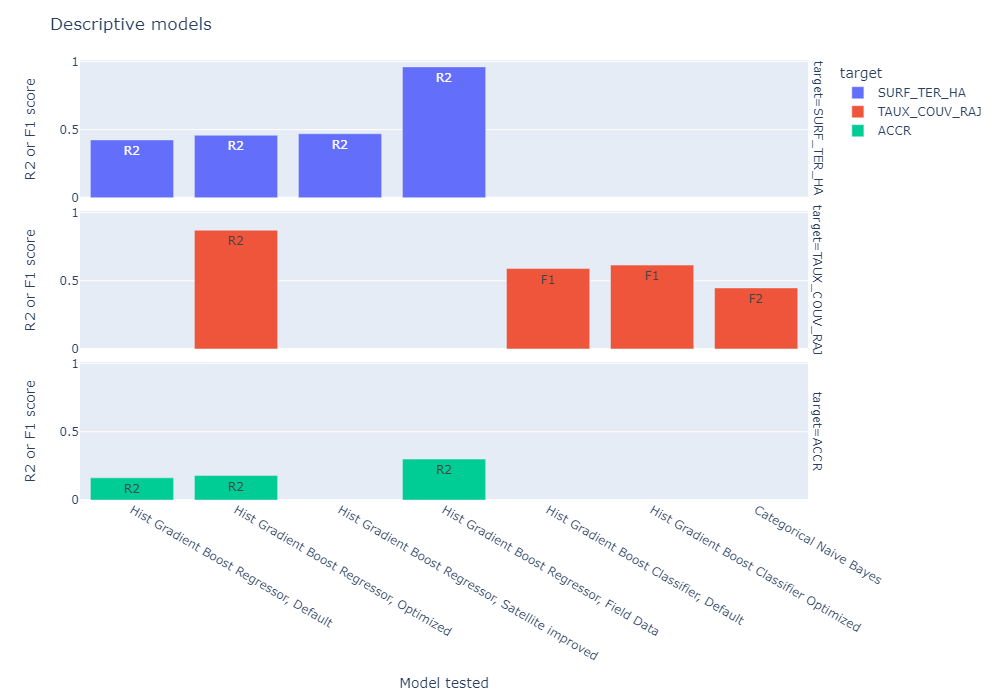

In [3]:
fig = px.bar(x="model_name", y = "score", data_frame=scores,text='metric',color='target',facet_row='target',
             labels={"model_name":"Model tested", "score":"R2 or F1 score"},
             width=1000,height=700)
fig.update_layout(title="Descriptive models")
fig.show('png')

Other things to try, with more time : 
- Obtain or infer (interpolate) more data points to improve our models and try new ones.
This would likely also require to scale observations to an interval (campaigns and data collection within is not regularized).

- From that point, given sufficient data points and robust understanding of the data, we could build RNN models with GRU layers and predict future growth.